# Checking 11k dataset

In [1]:
import os

import pandas as pd

In [2]:
data_path = '/home/dawars/datasets/11k'

In [3]:
metadata = pd.read_csv(os.path.join(data_path, 'HandInfo.csv'))
metadata.head()

,id,age,gender,skinColor,accessories,nailPolish,aspectOfHand,imageName,irregularities
0,0,27,male,fair,0,0,dorsal right,Hand_0000002.jpg,0
1,0,27,male,fair,0,0,dorsal right,Hand_0000003.jpg,0
2,0,27,male,fair,0,0,dorsal right,Hand_0000004.jpg,0
3,0,27,male,fair,0,0,dorsal right,Hand_0000005.jpg,0
4,0,27,male,fair,0,0,dorsal right,Hand_0000006.jpg,0


Load the list of processed filenames

In [4]:
processed_hands = []
with open(os.path.join(data_path, '2nd_pass/processed.txt')) as f:
    for line in f:    
        if line.strip().endswith('.jpg'):
            processed_hands.append(line.strip())

print(len(processed_hands))
print(processed_hands[:5])

5773
['Hand_0000067.jpg', 'Hand_0000069.jpg', 'Hand_0000102.jpg', 'Hand_0000103.jpg', 'Hand_0000104.jpg']


In [5]:
metadata = metadata[metadata['imageName'].isin(processed_hands)]
metadata.tail()

,id,age,gender,skinColor,accessories,nailPolish,aspectOfHand,imageName,irregularities
11071,1589,22,female,fair,0,0,palmar left,Hand_0011740.jpg,0
11072,1589,22,female,fair,0,0,palmar left,Hand_0011741.jpg,0
11073,1589,22,female,fair,0,0,palmar left,Hand_0011742.jpg,0
11074,1589,22,female,fair,0,0,palmar left,Hand_0011743.jpg,0
11075,1589,22,female,fair,0,0,palmar left,Hand_0011744.jpg,0


In [6]:
group = metadata.groupby('id').size()

In [7]:
group.index

Int64Index([      0,      10,      11,      12,      13,      19,      23,
                 25,      27,      38,
            ...
            1000000, 1100000, 1200000, 2000000, 3000000, 4000000, 6000000,
            7000000, 8000000, 9000000],
           dtype='int64', name='id', length=172)

## Saving joint locations in a pickle file

Cropping and resizing images

In [8]:
import shutil
import json
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

plt.rcParams['figure.figsize'] = [15, 8]

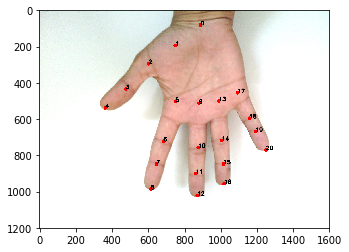

In [9]:
# plot joint order
#left

img = cv2.cvtColor(cv2.imread('/home/dawars/datasets/11k/Raw/Hand_0000187.jpg'), cv2.COLOR_BGR2RGB)

with open('/home/dawars/datasets/11k/1st_pass/Hand_0000187.jpg.right.json') as f:
    joints = json.load(f)
    for i, joint in enumerate(joints[0]):
        (x, y, prob) = joint
        pos = (int(x), int(y))
        cv2.circle(img, pos, 10, (255, 0, 0), thickness=cv2.FILLED)

        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(i), pos, font, 1, (0, 0, 0), 4, cv2.LINE_AA)
plt.imshow(img)
plt.imsave('right_joint_order.png', img)

In [10]:
def crop_img(img_path, joints, padding=50, size=224):
    """
    crop image to rectengular, resize to size
    :param img_path: img is in landscape
    :param joints: list of joint positions in pixels
    :param padding: padding outside of joint positions
    :param size: final image size
    :return: img in bgr format and rescaled joint locations
    """
    img = cv2.imread(img_path)
    height, width = img.shape[:2]

    joints = np.array(joints)
    y_min = int(max(0, joints[:, 1].min() - padding))
    y_max = int(min(height, joints[:, 1].max() + padding))
    bb_height = y_max - y_min
    x_middle = (joints[:, 0].min() + joints[:, 0].max()) / 2  # middle of hand in x direction

    x_min = int(x_middle - bb_height / 2)
    x_max = int(x_middle + bb_height / 2)

    if x_min < 0:
        x_max += 0 - x_min
        x_min = 0
    if x_max > width:
        x_min += width - x_max
        x_max = width

    # substract corner coordinates
    joints[:, :2] -= (x_min, y_min)
    # rescale
    joints[:, :2] *= size / bb_height
    # flip coords
    joints[:, :2] = size - joints[:, :2]

    # flipping along both axis ~ rotate 180 deg
    cropped_img = cv2.flip(img[y_min:y_max, x_min:x_max], -1)

    return cv2.resize(cropped_img, (size, size)), joints


In [15]:
joint_data = []
for file in processed_hands:
    #    shutil.copyfile(os.path.join(data_path, 'Raw',file), os.path.join(data_path, '11k_processed', file))
    for side in ['right', 'left']:
        try:
            name = os.path.join(data_path, '1st_pass', file + '.' + side + '.json')
            with open(name) as f:
                joints = json.load(f)[0]

                #cropped, tr_joints = crop_img(os.path.join(data_path, '11k_processed', file), joints)
                # check data-image correspondance
                # for x, y, prob in tr_joints:
                #     pos = (int(x), int(y))
                #     cv2.circle(cropped, pos, 2, (255, 0, 0), thickness=cv2.FILLED)
                # cv2.imwrite(os.path.join(data_path, 'cropped_joints', file), cropped)
                joint_data.append({
                    'filename': file,
                    'side': side,
                    'joints': joints,
                })
        except FileNotFoundError:
            pass
with open(os.path.join(data_path, '11k_joints.pkl'), 'wb') as f:
    pickle.dump(joint_data, f)
